#Gradient Boosting (applied to churn analysis)

*Gradient Boosting : The best off-the-shell supervised algorithm for Data Mining.*

**Summary : ** 
 
 - What is churn analysis
 - Process the data
 - Evaluate logistic regression's performance and see what's the problem
 - investigate decision tree
 - Some theory about Gradient Boosting
 - Evaluate performance of Gradient Boosting
 - Feature importance
 - Why GBDT is the best off-the-shell classifier for Data Mining.
 
** References **

 - *ref : T. Hastie, R. Tibshirani and J. Friedman. Elements of Statistical Learning Ed. 2, Springer, 2009.*

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV

from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.learning_curve import validation_curve
from sklearn.preprocessing import StandardScaler
from evaluation import deviance_curve
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
%matplotlib inline
import seaborn as sns
FIG_SIZE = (16,10)

## Churn Analysis

Churn analysis is about predicting if a customer is about to stop using a product or services. I'll not enter the details of the churning problem. It will just serve our purposes as a classification problem example. So given the attribute of a customer we want to predict if he's a potential churner. Of course in reality we would like to assess the health of the customer.



## Processing

The data comes from a telecom company. The data are messy meaning that the have categorical as well as continuous variables. There is no missing values though. The features are mostly self explanatory. 
Let's first take a look at the data. Those data has already been preprocessed and contains only binary and continuous variables. 

We see below that, as we could expect, the classes are extremely skewed. Less than 14% of the customers are churners. This is quite a lot though.

In [3]:
df = pd.read_csv('data/churn_cleaned.csv')
print("Proportion of churner : ", float(df[df['churn'] == True].shape[0])/df.shape[0])

('Proportion of churner : ', 0.14491449144914492)


We also note that the scales between the features are vastly differents. So we need to standardize the data set because we want to use logistic regression first. Note that for trees related methods we don't need any scaling, the alogrithm is agnostic to scales as well as variable types. He is omnivor and can eat whatever you want : categorical, ordinal, boolean, real. Of course if your categorical variables are string you need to dummify the variables first. 

In [4]:
labels = df['churn']
features = df.drop('churn', axis=1)
features_names = features.columns
features.head()

,Account Length,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
0,128,False,True,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,107,False,True,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,137,False,False,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,84,True,False,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,75,True,False,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3


### Normalization

In [5]:
BINARY_FEATURES_NAME = ["Int'l Plan", "VMail Plan"]
FEATURES_NAME = features.columns
continuous_feats = features.drop(BINARY_FEATURES_NAME, axis=1)
binary_feats = features[BINARY_FEATURES_NAME]
# Normalization of continuous variables :
continuous_feats.head()
binary_feats.head()
scaler = StandardScaler()
scaled_feats = pd.DataFrame(scaler.fit_transform(continuous_feats, FEATURES_NAME), columns=continuous_feats.columns)
normalized_feats = pd.concat([scaled_feats.T, binary_feats.T]).T
np.round(scaled_feats, decimals=2).head()

,Account Length,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
0,0.68,1.23,1.57,0.48,1.57,-0.07,-0.06,-0.07,0.87,-0.47,0.87,-0.09,-0.60,-0.09,-0.43
1,0.15,1.31,-0.33,1.12,-0.33,-0.11,0.14,-0.11,1.06,0.15,1.06,1.24,-0.60,1.24,-0.43
2,0.90,-0.59,1.17,0.68,1.17,-1.57,0.50,-1.57,-0.76,0.20,-0.76,0.70,0.21,0.70,-1.19
3,-0.43,-0.59,2.20,-1.47,2.20,-2.74,-0.61,-2.74,-0.08,-0.57,-0.08,-1.30,1.02,-1.31,0.33
4,-0.65,-0.59,-0.24,0.63,-0.24,-1.04,1.10,-1.04,-0.28,1.07,-0.28,-0.05,-0.60,-0.05,1.09


It would be a good idea to perform a pca and maybe a clustering on the continuous variables. 

We now separate the dataset into a training set on which we will do our experiments and a test set that we keep till the end to assess the performance.

In [6]:
# separating data into training and test set. The latter being kept till the end for performance assessment only
X_train, X_test, y_train, y_test = train_test_split(normalized_feats, labels, train_size=2500, random_state=0)

## Logistic Regression

Next we want to have an idea about the complexity of the classification task at hand. So we run a simple non-regularized logistic regression. Because the classes are skewed we fix the class_weight parameter at auto to take it into account.

In [7]:
lr = LogisticRegression(class_weight='auto')
XX_train, XX_valid, yy_train, yy_valid = train_test_split(X_train, y_train, train_size=1750, random_state=0) 
lr.fit(XX_train, yy_train)
yy_pred = lr.predict(XX_valid)
print(classification_report(yy_valid, yy_pred))

             precision    recall  f1-score   support

      False       0.94      0.80      0.87       639
       True       0.38      0.70      0.50       111

avg / total       0.86      0.79      0.81       750



We see that the performance is poor. The precision, i.e. the number of true churners among the predicted ones, is very low. The recall, i.e. the number of churners correctly predicted among the total number of churners, is not great neither. 

In conclusion :
    
- we predicted way too much non churners as churners.
- We do an average job at predicting that a chuners is indeed a churners

Note that what we want is a very high recall because we don't want to loose client. Precision is also important since we don't want to waste money by taking action with clients that don't require any specific actions. 

We may think that we need regularization, maybe we overfit a lot, though that would be very surprising.To get a better understanding we plot the **validation curve** or **deviance curves** of the F1-score with respect to a regularization parameter

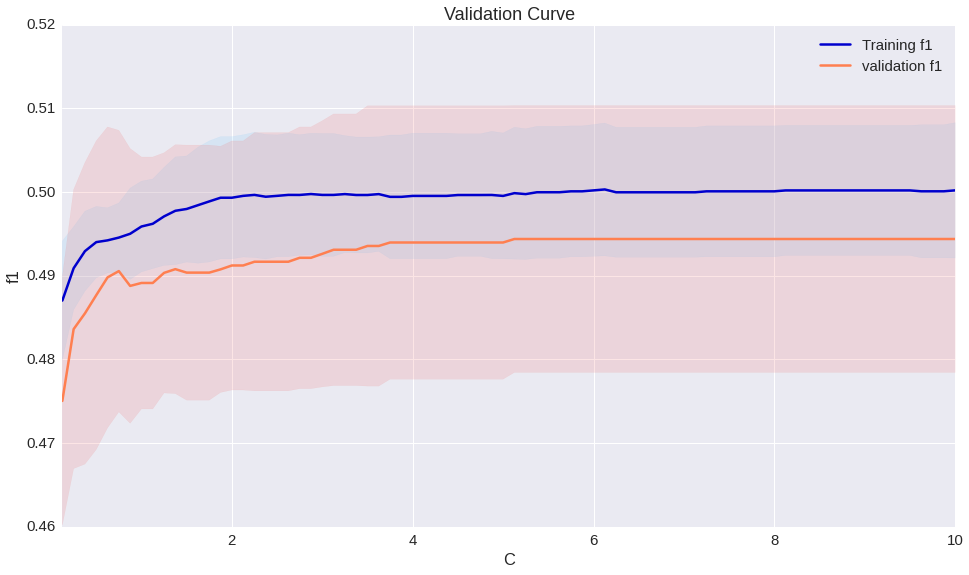

In [8]:
lr_reg = LogisticRegression(penalty="l2", class_weight="auto")
param_range = np.arange(0.125, 10.125, 0.125)
metric = "f1"
deviance_curve(lr_reg, X_train, y_train, "C", param_range=param_range, metric=metric, n_folds=5, njobs=-1)

The training F1-score is very low. This means that we are in a high biais situation so we need a more complex model. 

##Gradient Boosting Decision Trees

GBDT is the best off-the-shell machine learning algorithm, for many reasons, It is  :

 - extremely performant in most of the task, 
 - easily interpretable and can be applied in regression or classification problem. 
 - No scaling is needed and it works well whatever the variable type (categorical, binary, ordinal, continuous). 

###Brief description of the algorithm

Here is a bhrief description of the algorithm. Our goal is to give the intuition of the algorithm without giving too much details. For more details see ESL Chapter 9-10.

<u>Decision trees</u>
Decision trees can be used as classifier or regressor. The idea is very simple. Suppose we have a cost function 
$$ \sum_i L(\mathbf{x_i}, \mathbf{y_i}, p, \gamma) = \sum_{i\vert \mathbf{x}_i\in R_{\gamma_{-}}}L(\mathbf{x}_i, y_i) + \sum_{i\vert\mathbf{x}_i\in R_{\gamma_{+}}}L(\mathbf{x}_i, y_i)  $$ 
where $R_{\gamma^+}={\mathbf{x}\vert x_p < \gamma}$ and  $R_{\gamma^+}={\mathbf{x}\vert x_p > \gamma}$.

So the idea is to split the features space with respect to some of the predictor in such a way that the cost is minimal. Once this is done the same process is repeated in each of the region etc...

<u>Boosting</u>

** Meta parameters : **

<u> Max_depth </u>

The max_depth parameter controls the depth of the tree :
 
 - Deeper trees explained more variance at the expense of biais of course. 
 - The depth is directly correlated to the interaction between variables. A depth of 2 (called decision stump) deals only with main effect. 
 - Decision stumps maybe useful but it is pretty rare that high order interactions bring any values. 

Bottom line max_depth values between 4 and 8 give the best results in most cases. 

<u> n_estimators </u>

The n_estimators parameter control the number of boosting iterations. Each iterations reduce the training error leading to possible overfitting. This problem can be adress by monitoring the validation error

<u> learning_rate </u>

The learning rate $\alpha$ is another parameters that controls the scale at wich each tree contribute. The smaller the learning rate the higher the training risk for the same number of iteration. 

The regularization parameter interact with each other, smaller values of $\alpha$ leads to higher number of iterations. It appears that the best strategy is to choose a small value of $\alpha$ ($< 0.1$) and then choose the number of iterations accordingly. 

## Validation curve

The validation curve allow us to monitor overfitting. Again we plot a validation curve of the F1-score with respect to the n_estimators.

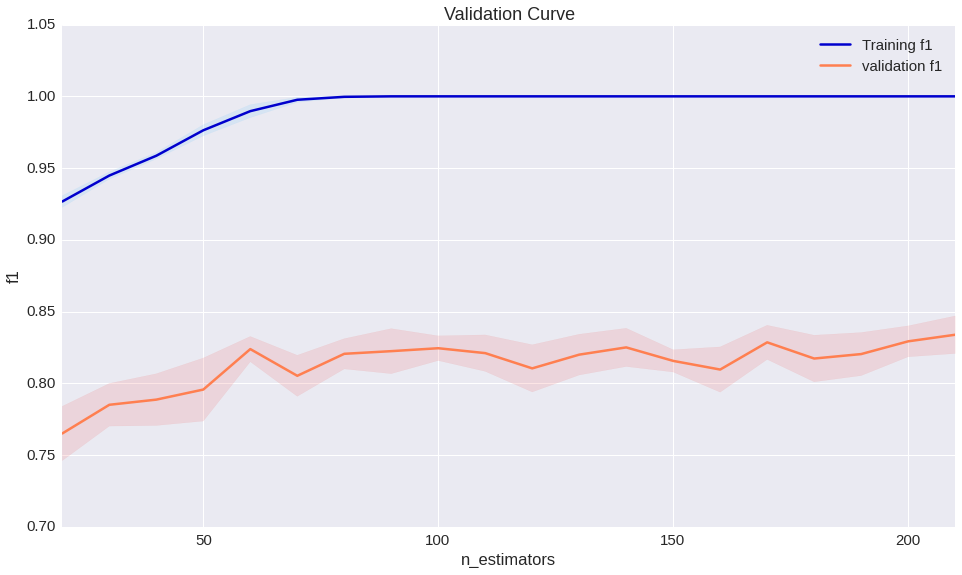

In [9]:
gb = GradientBoostingClassifier(max_depth=7, max_features='auto', learning_rate=0.1)
param_range = np.arange(20, 220, 10)
metric = "f1"
deviance_curve(gb, X_train, y_train, "n_estimators", param_range=param_range, metric=metric, n_folds=5, njobs=-1)

** Features importance Measures**

One of the nice feature of tree related methods is the fact that they give a measure of features importance. Because we split the features space using variable we can compute by how much a split participate to the loss function reduction. So given a variable we can see when this variable is involved into a split compute the amount by which the loss function decrease at each of those split and add them. Using ensemble method like gradient boosting or bagging (Random Forest) we can then just average over the number of iterations and then scale the results byt the max over all features. It should be noted that feature importance is strongly related to the tree architecture. Fortunately commity methors dampened this effect and are more reliable.

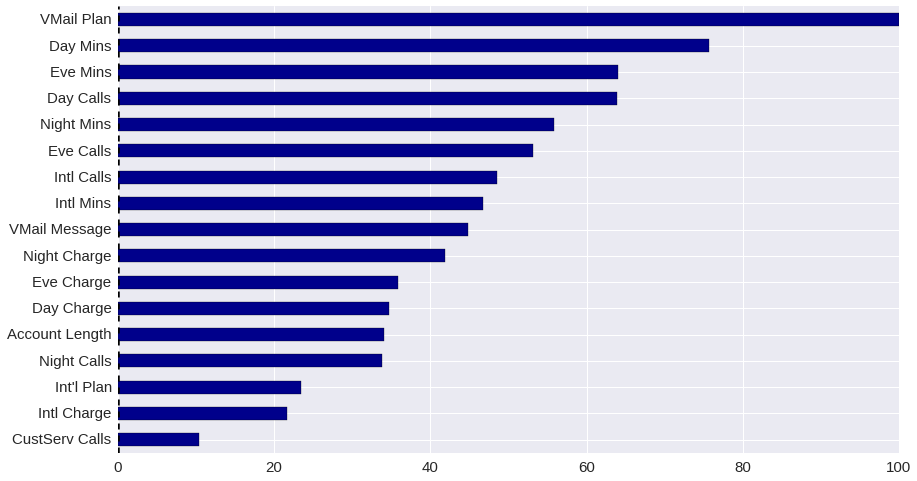

In [10]:
gb = GradientBoostingClassifier(max_depth=7, max_features='auto', learning_rate=0.1)
gb.fit(XX_train, yy_train)
importance_s = pd.Series(gb.feature_importances_, index=list(features_names))
importance_s /= importance_s.max()
importance_s *= 100
importance_s.sort()
sns.set_style("darkgrid")
importance_s.plot(kind='barh', color='darkblue', figsize=(14,8))

**Grid search**


In [11]:
# grid search
param_grid = {'n_estimators': np.arange(80, 136, 8), 'max_depth': [3, 4, 5, 6, 7]}
grid_search = GridSearchCV(gb, param_grid=param_grid, cv=3, verbose=0, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
       estimator=GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=7, max_features='auto', max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2, n_estimators=100,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=-1,
       param_grid={'n_estimators': array([ 80,  88,  96, 104, 112, 120, 128]), 'max_depth': [3, 4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [12]:
print("the winner is :", grid_search.best_params_)
print("with a score of : %f" % grid_search.best_score_)

('the winner is :', {'n_estimators': 128, 'max_depth': 7})
with a score of : 0.951600


In [13]:
gb_best = GradientBoostingClassifier(n_estimators=120, 
                                     max_depth=6, 
                                     max_features='auto', 
                                     learning_rate=0.1)
gb_best.fit(X_train, y_train)
y_pred = gb_best.predict(X_test)
proba_pred = gb_best.predict_proba(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

      False       0.97      0.98      0.98       718
       True       0.89      0.81      0.85       115

avg / total       0.96      0.96      0.96       833



## Using predicted probabilities as a health customer metric

As mentionned earlier it would be nice to have a metric or a set of metrics that measure to customer health. Because Gradient Boosting predict posterior probabilities to be in a class maybe we could use it. Unfortunately we will see that the predicted probabilities doesn't help at all in our situation. For example if we look at false negative, i.e. people that we churners but predicted as non-churners, the median posterior probability of being classified as non churners is ridiculously high. The same thing is true for false positive.

In [14]:
predictions = pd.DataFrame(y_test, columns=['genuine'])
predictions['pred'] = y_pred
predictions['proba_False'] = proba_pred[:, 0]
predictions['proba_True'] = proba_pred[:, 1]
predictions[predictions['genuine']  &  (predictions['pred']==False)].describe()

,genuine,pred,proba_False,proba_True
count,22,22,22.000000,22.000000
mean,1,0,0.911803,0.088197
std,0,0,0.143081,0.143081
min,True,False,0.508847,0.002368
25%,1,0,0.943172,0.007227
50%,1,0,0.986176,0.013824
75%,1,0,0.992773,0.056828
max,True,False,0.997632,0.491153


In [15]:
predictions[predictions['pred']  &  (predictions['genuine']==False)].describe()

,genuine,pred,proba_False,proba_True
count,12,12,12.000000,12.000000
mean,0,1,0.157308,0.842692
std,0,0,0.118093,0.118093
min,False,True,0.012080,0.644616
25%,0,1,0.064870,0.758410
50%,0,1,0.130289,0.869711
75%,0,1,0.241590,0.935130
max,False,True,0.355384,0.987920


In [18]:
predictions[predictions['genuine']].describe()

,genuine,pred,proba_False,proba_True
count,115,115,115.000000,115.000000
mean,1,0.8086957,0.237530,0.762470
std,0,0.3950495,0.347733,0.347733
min,True,False,0.000347,0.002368
25%,1,1,0.016300,0.709149
50%,1,1,0.049700,0.950300
75%,1,1,0.290851,0.983700
max,True,True,0.997632,0.999653
